Решение одномерной краевой задачи колебаний из методического пособия по математической физике за 6 семестр за авторством Пожарского А.А, задача № 48.7

$
\begin{cases}
    u_{tt} = u_{xx} + t, & 0 < x < \pi \\
    u = 0, & x = 0 \\
    u = 0, & x = \pi \\
    u = 0, & t = 0 \\
    u_t = 3 \sin{2 x}, & t = 0
\end{cases}
$

Аналитическое решение:

$
u = \frac{3}{2} \sin{2 t} \sin{2 x} + \frac{2}{\pi} \sum_{n=1}^{\infty} \frac{1 - (-1)^n}{n^4} (n t - \sin{n t}) \sin{n x}
$

In [7]:
import time
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, replace, asdict, field
import math
from contextlib import nullcontext
import json

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
from tqdm import trange

from NN_pytorch_BVP.pinn import MultilayerPerceptronWithFFE, compute_grad_theta_norm, sample_points_2D

mpl.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 1.0,   # optional
})
            
# Для аккуратного масштабирования пределов оси Y во время рендера анимации обучения
def smooth_autoscale_y_hysteresis(ax, y, pad=0.05, alpha_shrink=0.08):
    """
    Smoothly adjust the y-axis limits to follow streaming data.

    Each call computes target y-limits from the current data `y` (with a small
    padding), then updates the axes limits with hysteresis:
      - expand immediately if the new data exceeds the current limits (avoid clipping)
      - shrink gradually toward tighter limits (reduce jitter/"breathing")

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes whose y-limits will be updated.
    y : array-like
        Current y-data (list/NumPy array/torch tensor converted to array).
    pad : float, default=0.05
        Fractional padding added above and below the data range.
    alpha_shrink : float, default=0.08
        Smoothing factor for shrinking (0 < alpha <= 1). Smaller = smoother/slower.
    """
    y = np.asarray(y)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if ymin == ymax:
        ymin -= 1.0
        ymax += 1.0

    yr = ymax - ymin
    ymin_t = ymin - pad * yr
    ymax_t = ymax + pad * yr

    cur_ymin, cur_ymax = ax.get_ylim()

    # Expand immediately if needed
    if ymin_t < cur_ymin:
        cur_ymin = ymin_t
    else:  # shrink slowly
        cur_ymin = (1 - alpha_shrink) * cur_ymin + alpha_shrink * ymin_t

    if ymax_t > cur_ymax:
        cur_ymax = ymax_t
    else:
        cur_ymax = (1 - alpha_shrink) * cur_ymax + alpha_shrink * ymax_t

    ax.set_ylim(cur_ymin, cur_ymax)

torch.manual_seed(2008)
 
@dataclass(frozen=True)
class PINNConfig:
    # Problem parameters
    xlims: list[float] = field(default_factory=lambda: [0.0, torch.pi])    # x_min, x_max
    tlims: list[float] = field(default_factory=lambda: [0.0, 2.0*torch.pi])    # t_min, t_max

    # Model parameters
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    init_scheme: str = "glorot_normal"
    layers: list[int] = field(default_factory=lambda: [2, 256, 256, 1]) 

    # Training parameters
    results_folder: Path = Path.cwd() / 'runs' / "wave_equation_1d_Pozharsky48_7"
    n_epochs: int = 5000
    n_points: int = 1000
    lambda_r: float = 1.0
    lambda_ic: float = 1.0
    lambda_bc: float = 1.0
    lr: float = 1e-3    # initial learning rate
    use_static_training_set: bool = False
    logging_freq: int = 1    # log metrics once every N gradient descent steps

    # Checkpointing
    use_checkpointing: bool = False
    checkpointing_freq: int = 2000    # save model and metrics to the results_folder once every N gradient descent steps

    # Fourier Feature embedding
    use_FFE: bool = False
    FFE_m: int = 100
    FFE_sigma: float = 1.0
    FFE_keep_dims: None | list[int] = None    # Indices of input dimensions to be passed through unchanged

    # Grad norm weighting
    use_grad_norm_weighting: bool = False
    grad_norm_weighting_alpha: float = 0.9
    grad_norm_weighting_freq: int = 200    # update lambdas once every N gradient descent steps

    # Causal weighting
    use_causal_weighting_scheme: bool = False
    causal_m: int = 10
    causal_eps: float = 100.0
    W_logging_freq: int = 100    # log temporal weights and L_t once every N gradient descent steps

    # Video parameters
    render_video: bool = False
    video_fps: int = 30
    video_dpi: int = 100
    video_render_freq: int = 100    # render a frame once every N gradient descent steps

class Trainer:
    def __init__(self, model, optimizer, scheduler, cfg: PINNConfig):
        self.model = model.to(cfg.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.cfg = cfg
        self.results_folder = self.cfg.results_folder
        self.results_folder.mkdir(parents=True, exist_ok=True)

        if cfg.use_checkpointing:
            (self.results_folder / "model").mkdir(parents=True, exist_ok=True)
            (self.results_folder / "metrics").mkdir(parents=True, exist_ok=True)

        # Save cfg dataclass object to the results folder as json
        def to_jsonable(x):
            if isinstance(x, Path):
                return str(x)
            if isinstance(x, torch.device):
                return str(x)
            return x
        data = {k: to_jsonable(v) for k, v in asdict(cfg).items()}
        del data["results_folder"]
        (self.results_folder / "config.json").write_text(json.dumps(data, indent=2))

        self.xlims = list(cfg.xlims)
        self.tlims = list(cfg.tlims)
        self.device = cfg.device
        self.use_static_training_set = cfg.use_static_training_set

        self.grad_norm_weighting_alpha = cfg.grad_norm_weighting_alpha
        self.use_causal_weighting_scheme = cfg.use_causal_weighting_scheme
        self.causal_m = cfg.causal_m
        self.causal_eps = cfg.causal_eps

    def u_exact(self, tx, n_max=100):
        t = tx[:, 0:1]
        x = tx[:, 1:2]

        tmp = 0.0
        for n in range(1, n_max+1):
            tmp += (1 - (-1)**n) / n**4 * (n * t - torch.sin(n*t)) * torch.sin(n*x) 

        return 1.5 * torch.sin(2.0 * t) * torch.sin(2.0 * x) + 2.0 / torch.pi * tmp
        
    def sample_points(self, n: int):
        x_min, x_max = self.xlims
        t_min, t_max = self.tlims

        tx_r = sample_points_2D([t_min, x_min, t_max, x_max], n, scheme="uniform", device=self.device)
        tx_r.requires_grad_(True)

        n_ic = n
        tx_ic = sample_points_2D([t_min, x_min, t_min, x_max], n_ic, scheme="uniform", device=self.device)
        tx_ic.requires_grad_(True)

        n_bc = n
        tx_bc1 = sample_points_2D([t_min, x_min, t_max, x_min], n_bc // 2, scheme="uniform", device=self.device)
        tx_bc2 = sample_points_2D([t_min, x_max, t_max, x_max], n_bc // 2, scheme="uniform", device=self.device)
        tx_bc = torch.cat([tx_bc1, tx_bc2], dim=0)
        tx_bc.requires_grad_(True)

        return tx_r, tx_ic, tx_bc

    def compute_loss_terms(self, tx_r, tx_ic, tx_bc, lambda_r=1.0, lambda_ic=1.0, lambda_bc=1.0, update_lambdas=False):
        model = self.model
        optimizer = self.optimizer
        use_causal_weighting_scheme = self.use_causal_weighting_scheme
        causal_m = self.causal_m
        causal_eps = self.causal_eps
        t_min, t_max = self.tlims
        
        u_r = model(tx_r)
        u_ic = model(tx_ic)
        u_bc = model(tx_bc)

        # Compute loss_r
        tmp = torch.autograd.grad(u_r, tx_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        u_t = tmp[:, 0:1]
        u_x = tmp[:, 1:2]
        u_xx = torch.autograd.grad(u_x, tx_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
        u_tt = torch.autograd.grad(u_t, tx_r, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 0:1]
        res_r = u_tt - u_xx - tx_r[:, 0:1]
        if use_causal_weighting_scheme:
            t_flat = tx_r[:, 0].detach().squeeze(-1)
            L_t = torch.zeros(causal_m, device=self.device)
            h = (t_max - t_min) / causal_m
            for i in range(causal_m):
                mask = ((t_min + i * h < t_flat) & (t_flat <= t_min + (i + 1) * h))
                if mask.any():
                    L_t[i] = torch.mean(res_r[mask]**2)
                else:
                    L_t[i] = 0.0
            M = torch.tril(torch.ones(causal_m, causal_m, device=self.device), diagonal=-1)
            W = torch.exp(-causal_eps * (M @ L_t)).detach()
            loss_r = (W * L_t).mean()
        else:
            loss_r = torch.mean(res_r**2)
        if update_lambdas:
            optimizer.zero_grad()
            loss_r.backward(retain_graph=True)
            grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_ic
        u_x_ic = torch.autograd.grad(u_ic, tx_ic, grad_outputs=torch.ones_like(u_r), create_graph=True)[0][:, 0:1]
        res_ic1 = u_ic
        res_ic2 = u_x_ic - 3.0 * torch.sin(2.0*tx_ic[:, 1:2])
        loss_ic = torch.mean(res_ic1**2) + torch.mean(res_ic2**2)
        if update_lambdas:
            optimizer.zero_grad()
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        # Computer loss_bc
        # x_min, x_max = self.xlims
        # id1 = torch.nonzero( torch.abs(tx_bc[:, 1] - x_min) < 1e-4 ).squeeze()
        # id2 = torch.nonzero( torch.abs(tx_bc[:, 1] - x_max) < 1e-4 ).squeeze()
        # res_bc = torch.empty(u_bc.shape, dtype=u_bc.dtype, device=u_bc.device)
        # res_bc[id1] = u_bc[id1]
        # res_bc[id2] = u_bc[id2]
        res_bc = u_bc
        loss_bc = torch.mean( res_bc**2 )
        if update_lambdas:
            optimizer.zero_grad()
            loss_bc.backward(retain_graph=True)
            grad_loss_bc_theta_norm = compute_grad_theta_norm(model)

        # Compute new lambdas if needed
        if update_lambdas:
            tmp = grad_loss_r_theta_norm + grad_loss_ic_theta_norm + grad_loss_bc_theta_norm
            alpha = self.grad_norm_weighting_alpha
            lambda_r = alpha*lambda_r + (1.0 - alpha) * tmp / grad_loss_r_theta_norm
            lambda_ic = alpha*lambda_ic + (1.0 - alpha) * tmp / grad_loss_ic_theta_norm
            lambda_bc = alpha*lambda_bc + (1.0 - alpha) * tmp / grad_loss_bc_theta_norm

        loss = lambda_r * loss_r + lambda_ic * loss_ic + lambda_bc * loss_bc

        return (loss, loss_r, loss_ic, loss_bc, lambda_r, lambda_ic, lambda_bc,
                res_r, res_ic1, res_ic2, res_bc,
                W if use_causal_weighting_scheme else None, L_t if use_causal_weighting_scheme else None)

    def train(self):
        n_epochs = self.cfg.n_epochs
        use_grad_norm_weighting = self.cfg.use_grad_norm_weighting
        grad_norm_weighting_freq = self.cfg.grad_norm_weighting_freq
        use_causal = self.use_causal_weighting_scheme
        optimizer = self.optimizer
        scheduler = self.scheduler
        lambda_r = self.cfg.lambda_r
        lambda_ic = self.cfg.lambda_ic
        lambda_bc = self.cfg.lambda_bc
        use_static_training_set = self.use_static_training_set
        n_points = self.cfg.n_points
        device = self.device
        W_logging_freq = self.cfg.W_logging_freq
        logging_freq = self.cfg.logging_freq
        x_min, x_max = self.xlims
        t_min, t_max = self.tlims
        causal_m = self.cfg.causal_m
        render_video = self.cfg.render_video
        model = self.model
        use_checkpointing = self.cfg.use_checkpointing
        checkpointing_freq = self.cfg.checkpointing_freq
        results_folder = self.results_folder

        # Для логирования
        n_log = n_epochs // logging_freq
        n_wlog = n_epochs // W_logging_freq
        metrics = {
            "step": torch.arange(0, n_epochs, logging_freq),
            "loss": torch.zeros(n_log),
            "loss_r": torch.zeros(n_log),
            "loss_ic": torch.zeros(n_log),
            "loss_bc": torch.zeros(n_log),
            "err_l2": torch.zeros(n_log),
            "rel_err_l2": torch.zeros(n_log),
            "lambda_r": torch.zeros(n_log),
            "lambda_ic": torch.zeros(n_log),
            "lambda_bc": torch.zeros(n_log),
            "lr": torch.zeros(n_log),

            "W_step": torch.arange(0, n_epochs, W_logging_freq),
            "W": [None] * n_wlog,
            "L_t": [None] * n_wlog
        }

        # Video
        video_path = results_folder / ("training_animation_" + ".mp4")
        video_render_freq = self.cfg.video_render_freq

        # tx = sample_points_2D([t_min, x_min, t_max, x_max], n_points, scheme="uniform", device=device)
        # tx[0] = torch.tensor([t_min, x_min], device=device)    # corners
        # tx[1] = torch.tensor([t_min, x_max], device=device)
        # tx[2] = torch.tensor([t_max, x_min], device=device)
        # tx[3] = torch.tensor([t_max, x_max], device=device)
        tx = torch.cartesian_prod(
            torch.linspace(t_min, t_max, 150, device=device),
            torch.linspace(x_min, x_max, 150, device=device)
        )
        u_exact_arr = self.u_exact(tx).detach().cpu()
        u_exact_arr_l2 = torch.norm(u_exact_arr, p=2).item()

        ### ДЛЯ АНИМАЦИИ ПРОЦЕССА ОБУЧЕНИЯ
        if render_video:
            writer = anim.FFMpegWriter(
                fps=self.cfg.video_fps, 
                codec='libx264', 
                extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
            )
            w, h = plt.rcParams['figure.figsize']
            w *= 0.6
            h *= 0.6

            # model(t)
            fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(3*w, 2*h), constrained_layout=True)
            pc1 = ax1.tripcolor(
                tx[:, 0].detach().cpu(), tx[:, 1].detach().cpu(), u_exact_arr.reshape(-1), 
                vmin=u_exact_arr.min().item(), vmax=u_exact_arr.max().item(), shading="gouraud", cmap="coolwarm")
            ax1.set(title="Exact vs model solutions", xlabel="$t$", ylabel="$x$", xlim=self.tlims, ylim=self.xlims)
            fig.colorbar(pc1, ax=ax1)

            # # Error
            # (line2, ) = ax2.plot(t.detach().cpu(), torch.zeros(t.shape))
            # ax2.set(title="Error = u_exact(t) - model(t)", xlabel="$t$", ylabel="error", ylim=[-0.5, 0.5])
            # ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

            # # Residual inside domain
            # (line3, ) = ax3.plot(torch.zeros(n_points), torch.zeros(n_points))
            # ax3.set(title="Residual inside domain", xlabel="$t$", ylabel="res_r", xlim=domain)
            # ax3.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

            # loss
            (line4, ) = ax4.semilogy(metrics["step"], metrics["loss"] + 0.1, label='loss')
            ax4.set(title="loss", xlabel='grad step', ylim=[1e-4, 10])
            ax4.legend()

            # Temporal weights
            (line5, ) = ax5.plot(torch.arange(causal_m), torch.zeros(causal_m))
            ax5.set(title="Temporal weights $w_i$", xlabel="$i$", ylabel="$w_i$", ylim=[0, 1.1])

            # L_t
            (line6, ) = ax6.semilogy(torch.arange(causal_m), torch.ones(causal_m))
            ax6.set(title="$\\mathcal{L}_{r}^{i}$", xlabel="$i$", ylabel="$\\mathcal{L}_{r}^{i}$", ylim=[1e-5, 1])

        pbar = trange(n_epochs)
        with writer.saving(fig, video_path, dpi=self.cfg.video_dpi) if render_video else nullcontext():
            for iter in pbar:
                if iter == 0 or (not use_static_training_set):
                    tx_r, tx_ic, tx_bc = self.sample_points(n_points)
                if use_static_training_set:    # re-leaf tensors
                    tx_r = tx_r.detach().requires_grad_(True)
                    tx_ic = tx_ic.detach().requires_grad_(True)
                    tx_bc = tx_bc.detach().requires_grad_(True)
                loss, loss_r, loss_ic, loss_bc, lambda_r, lambda_ic, lambda_bc, res_r, res_ic1, res_ic2, res_bc, W, L_t = self.compute_loss_terms(
                    tx_r, tx_ic, tx_bc, lambda_r=lambda_r, lambda_ic=lambda_ic, lambda_bc=lambda_bc, 
                    update_lambdas = use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0)

                self.optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if use_causal and iter % W_logging_freq == 0:
                    i = iter // W_logging_freq
                    metrics["W"][i] = W.detach().cpu().numpy()
                    metrics["L_t"][i] = L_t.detach().cpu().numpy()
                
                if iter % logging_freq == 0:
                    i = iter // logging_freq
                    metrics["loss"][i] = loss.item()
                    metrics["loss_r"][i] = loss_r.item()
                    metrics["loss_ic"][i] = loss_ic.item()
                    metrics["loss_bc"][i] = loss_bc.item()
                    metrics["err_l2"][i] = torch.norm(u_exact_arr - model(tx).detach().cpu(), p=2).item()
                    metrics["rel_err_l2"][i] = metrics["err_l2"][i] / u_exact_arr_l2 * 100
                    metrics["lambda_r"][i] = lambda_r
                    metrics["lambda_ic"][i] = lambda_ic
                    metrics["lambda_bc"][i] = lambda_bc
                    metrics["lr"][i] = optimizer.param_groups[0]["lr"]

                    pbar.set_postfix({
                        'loss': metrics["loss"][i].item(),
                        "err_l2": metrics["err_l2"][i].item(),
                        "rel_err_l2": metrics["rel_err_l2"][i].item(),
                        'lambda_r': metrics["lambda_r"][i].item(),
                        'lambda_ic': metrics["lambda_ic"][i].item(),
                        'lambda_bc': metrics["lambda_bc"][i].item()
                    })

                # Рендер кадра анимации
                if render_video and iter % video_render_freq == 0:
                    u_approx = model(tx).detach().cpu()
                    pc1.set_array(u_approx.reshape(-1))
                    # line2.set_data(t.detach().cpu(), u_exact_arr - u_approx)
                    # smooth_autoscale_y_hysteresis(ax2, line2.get_ydata())
                    # t_r_sorted, t_r_idx = torch.sort(t_r.squeeze(-1))
                    # res_sorted = res_r.squeeze(-1)[t_r_idx]
                    # line3.set_data(t_r_sorted.detach().cpu(), res_sorted.detach().cpu())
                    # smooth_autoscale_y_hysteresis(ax3, line3.get_ydata())
                    line4.set_data(np.arange(0, iter + 1, logging_freq), metrics["loss"][:iter//logging_freq+1])
                    if use_causal:
                        line5.set_ydata(W.detach().cpu())
                        line6.set_ydata(L_t.detach().cpu())
                    writer.grab_frame()

                if use_checkpointing and ( (iter + 1) % checkpointing_freq == 0  or (iter + 1) == n_epochs):
                    # save model
                    model_path = results_folder / "model" / ("model_epoch=" + str(iter + 1) + ".pth")
                    MultilayerPerceptronWithFFE.save(model, model_path)    

                    # save metrics
                    metrics_path = results_folder / "metrics" / ("metrics_epoch=" + str(iter + 1) + ".pth")
                    torch.save(metrics, metrics_path)

        return metrics
    
    def render_metrics_plots(self, metrics: dict, show=True, save_to_disk: bool = False, fmt: str ="png"):
        if save_to_disk:
            plot_path = self.results_folder / "plots"
            plot_path.mkdir(parents=True, exist_ok=True)

        w, h = plt.rcParams['figure.figsize']
        x_min, x_max = self.xlims
        t_min, t_max = self.tlims
        device = self.device

        def show_plot(fig, show):
            if not show:
                plt.close(fig)

        def save_fig(fig, save_path: Path, dpi: int = 300):
            if save_to_disk:
                fig.tight_layout()
                fig.savefig(save_path, dpi=dpi)
        
        # Losses
        fig, ax = plt.subplots()
        ax.set(title="Losses", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["loss"], label="loss")
        ax.semilogy(metrics["step"], metrics["loss_r"], label="loss_r")
        ax.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic")
        ax.semilogy(metrics["step"], metrics["loss_bc"], label="loss_bc")
        ax.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses" + "." + fmt))
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(2*w, 2*h))
        ax1.semilogy(metrics["step"], metrics["loss"], label="loss", color='C0')
        ax1.legend()
        ax2.semilogy(metrics["step"], metrics["loss_r"], label="loss_r", color='C1')
        ax2.legend()
        ax3.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic", color='C2')
        ax3.legend()
        ax4.semilogy(metrics["step"], metrics["loss_bc"], label="loss_bc", color='C3')
        ax4.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses_separate" + "." + fmt))

        # Error
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
        ax1.plot(metrics["step"], metrics["err_l2"])
        ax1.set(title="Error L2 norm", xlabel="grad step")
        ax2.plot(metrics["step"], metrics["rel_err_l2"])
        ax2.set(title="Relative error L2 norm", xlabel="grad step", ylabel="%")
        show_plot(fig, show)
        save_fig(fig, plot_path / ("error" + "." + fmt))

        # Lambdas
        if self.cfg.use_grad_norm_weighting:
            fig, ax = plt.subplots()
            ax.plot(metrics["step"], metrics["lambda_r"], label="lambda_r")
            ax.plot(metrics["step"], metrics["lambda_ic"], label="lambda_ic")
            ax.plot(metrics["step"], metrics["lambda_bc"], label="lambda_bc")
            ax.set_xlabel("grad step")
            ax.legend()
            show_plot(fig, show)
            save_fig(fig, plot_path / ("lambdas" + "." + fmt))

        # Temporal weights
        if self.cfg.use_causal_weighting_scheme:
            W = np.stack(metrics["W"])
            t = np.arange(W.shape[1])
            fig, ax = plt.subplots()
            pm = ax.pcolormesh(t, metrics["W_step"], W, shading='auto', cmap='binary')
            cbar = fig.colorbar(pm, ax=ax)
            ax.set(title="Temporal weights $w_i$ over training", xlabel="$i$", ylabel="gradient step")
            show_plot(fig, show)
            save_fig(fig, plot_path / ("temporal_weights" + "." + fmt))

        # L_t
        if self.cfg.use_causal_weighting_scheme:
            L_t = np.stack(metrics["L_t"])
            t = np.arange(L_t.shape[1])
            fig, ax = plt.subplots()
            pm = ax.pcolormesh(t, metrics["W_step"], L_t, shading='auto', cmap='binary',
                norm=colors.LogNorm())
            cbar = fig.colorbar(pm, ax=ax)
            ax.set(title="$\\mathcal{L}_{r}^{i}$ for gradient steps", xlabel="$i$", ylabel="grad step")
            show_plot(fig, show)
            save_fig(fig, plot_path / ("l_t" + "." + fmt))

        # Learning rate
        fig, ax = plt.subplots()
        ax.set(title="Learning rate", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["lr"])
        show_plot(fig, show)
        save_fig(fig, plot_path / ("learning_rate" + "." + fmt))

        # Model vs reference solution
        with torch.no_grad():
            model = self.model.to("cpu")
            tx = torch.cartesian_prod(
                torch.linspace(t_min, t_max, 100, device=device),
                torch.linspace(x_min, x_max, 100, device=device)
            )
            u_exact_arr = self.u_exact(tx).reshape(-1)
            u_model = model(tx).reshape(-1)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
            ax1.set(title="Model solutions", xlabel="t", ylabel="x", xlim=self.tlims, ylim=self.xlims)
            pc1 = ax1.tripcolor(tx[:, 0], tx[:, 1], u_model, 
                shading="gouraud", cmap="coolwarm")
            fig.colorbar(pc1, ax=ax1)
            ax2.set(title="Model solutions - exact solution", xlabel="t", ylabel="x", xlim=self.tlims, ylim=self.xlims)
            pc2 = ax2.tripcolor(tx[:, 0], tx[:, 1], u_model - u_exact_arr, 
                shading="gouraud", cmap="coolwarm")
            fig.colorbar(pc2, ax=ax2)
            show_plot(fig, show)
            save_fig(fig, plot_path / ("model_vs_reference_solutions" + "." + fmt))

Запуск обучения без каких-либо улучшений

100%|██████████| 10000/10000 [02:28<00:00, 67.19it/s, loss=0.00164, err_l2=6.46, rel_err_l2=1.19, lambda_r=1, lambda_ic=1, lambda_bc=1]


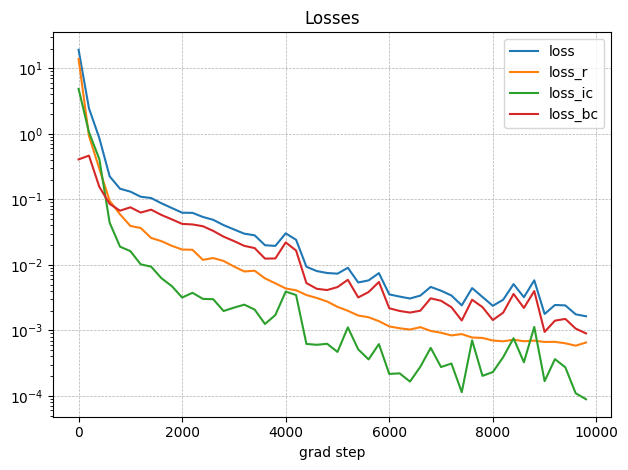

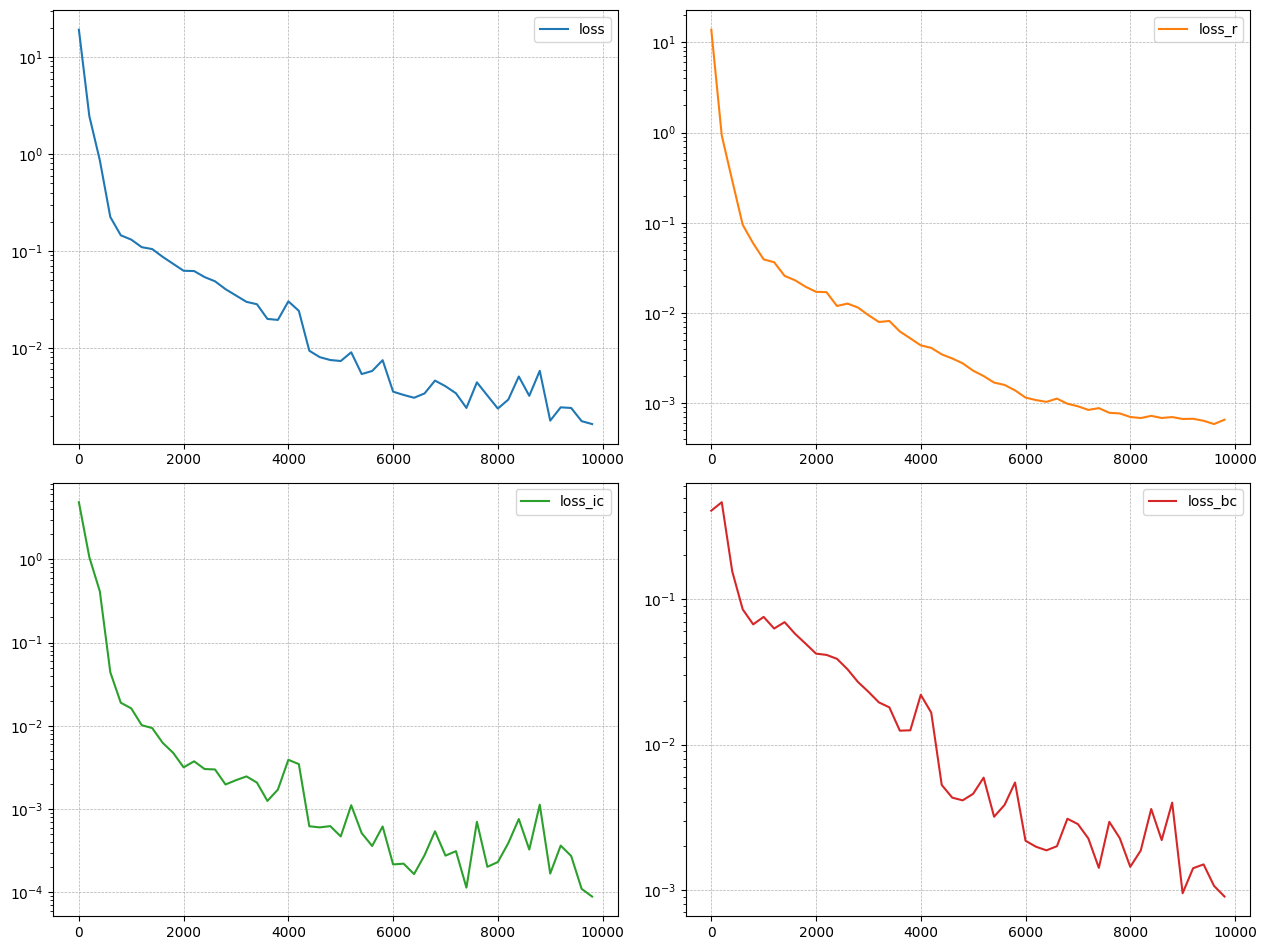

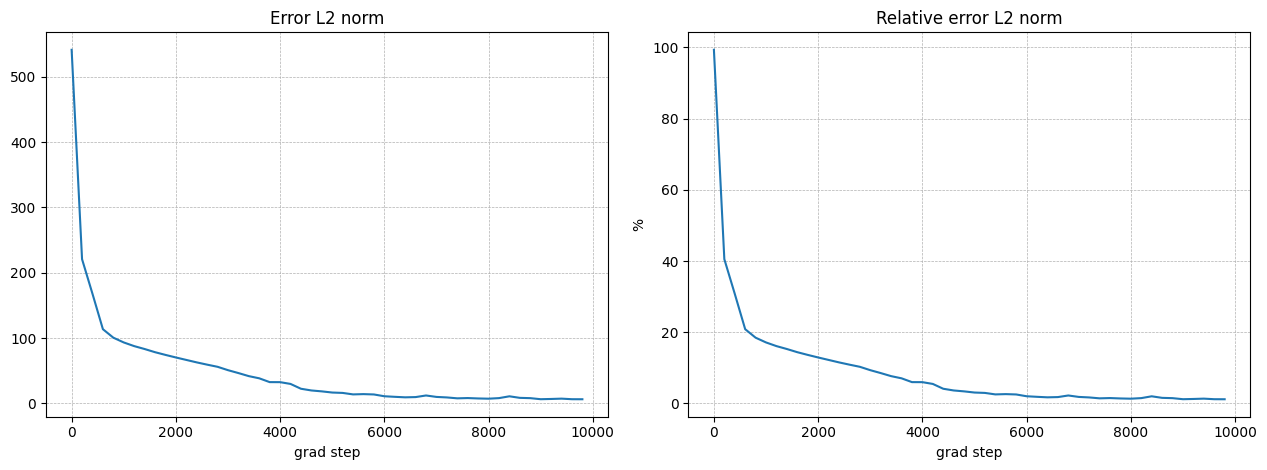

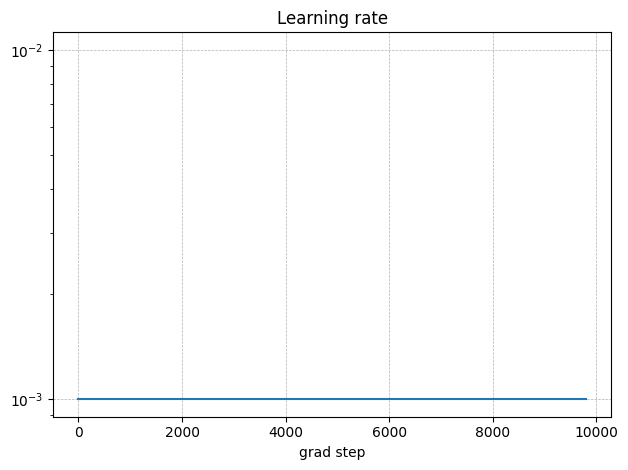

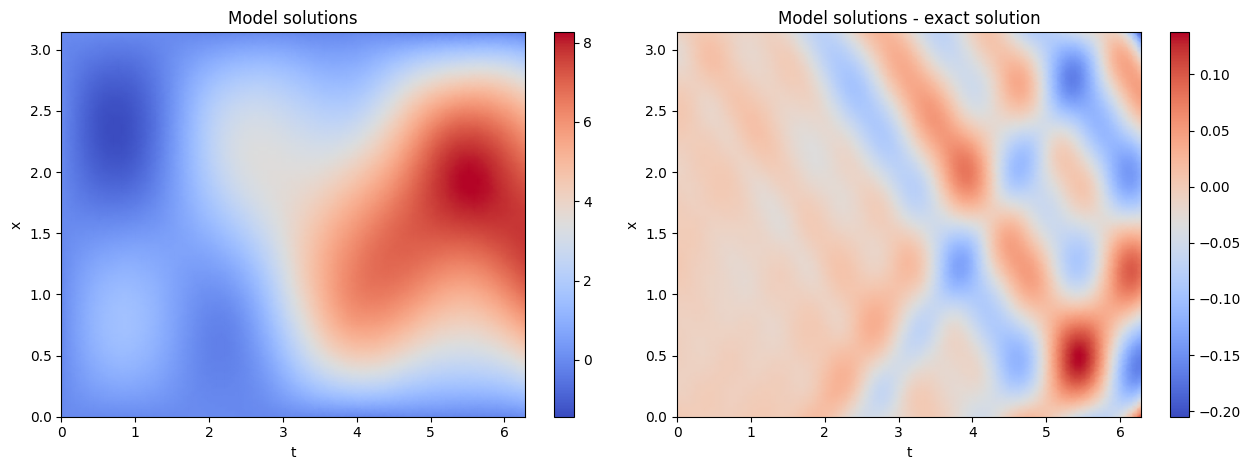

In [8]:
config_baseline = PINNConfig(
    n_epochs=10000,
    n_points=1000,
    logging_freq=200,
    layers=[2, 128, 128, 1],
    results_folder=PINNConfig.results_folder / "baseline",
    use_causal_weighting_scheme=False,
    causal_m=4,
    causal_eps=0.5, 
    W_logging_freq=500,
    use_grad_norm_weighting=False,
    grad_norm_weighting_alpha=0.95,
    grad_norm_weighting_freq=250,
    use_FFE=False,
    FFE_keep_dims=[0],
    FFE_m=3,
    use_checkpointing=True,
    checkpointing_freq=2000)
model_baseline = MultilayerPerceptronWithFFE(
    config_baseline.layers, config_baseline.init_scheme,
    use_FFE=config_baseline.use_FFE, FFE_m=config_baseline.FFE_m, 
    FFE_sigma=config_baseline.FFE_sigma, FFE_keep_dims=config_baseline.FFE_keep_dims)
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=config_baseline.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_baseline = Trainer(model_baseline, optimizer, scheduler, cfg=config_baseline)
metrics_baseline = trainer_baseline.train()

trainer_baseline.render_metrics_plots(metrics_baseline, save_to_disk=True)

Запуск обучения с полным FFE

100%|██████████| 10000/10000 [03:14<00:00, 51.50it/s, loss=0.00194, err_l2=2.29, rel_err_l2=0.42, lambda_r=1, lambda_ic=1, lambda_bc=1]


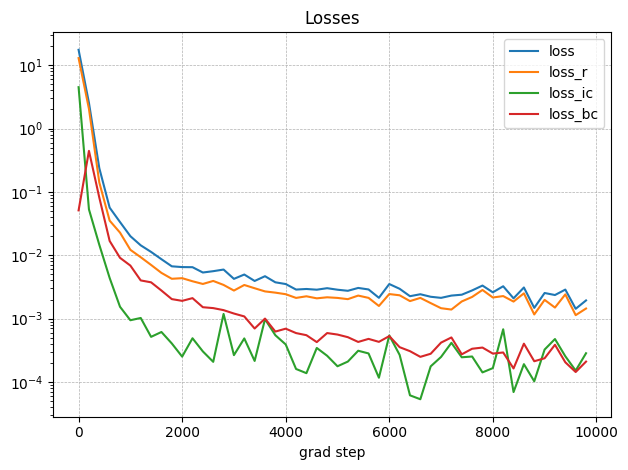

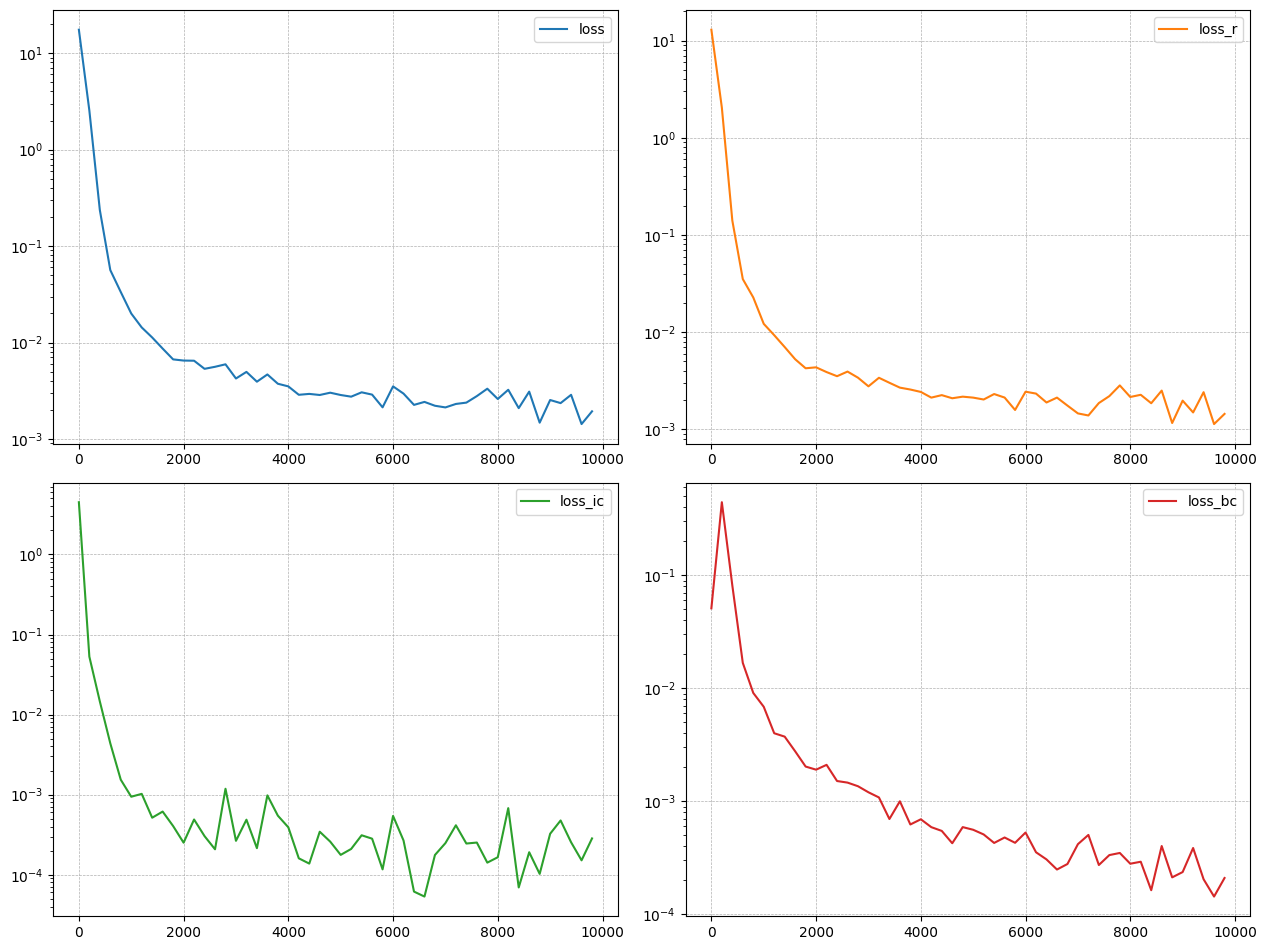

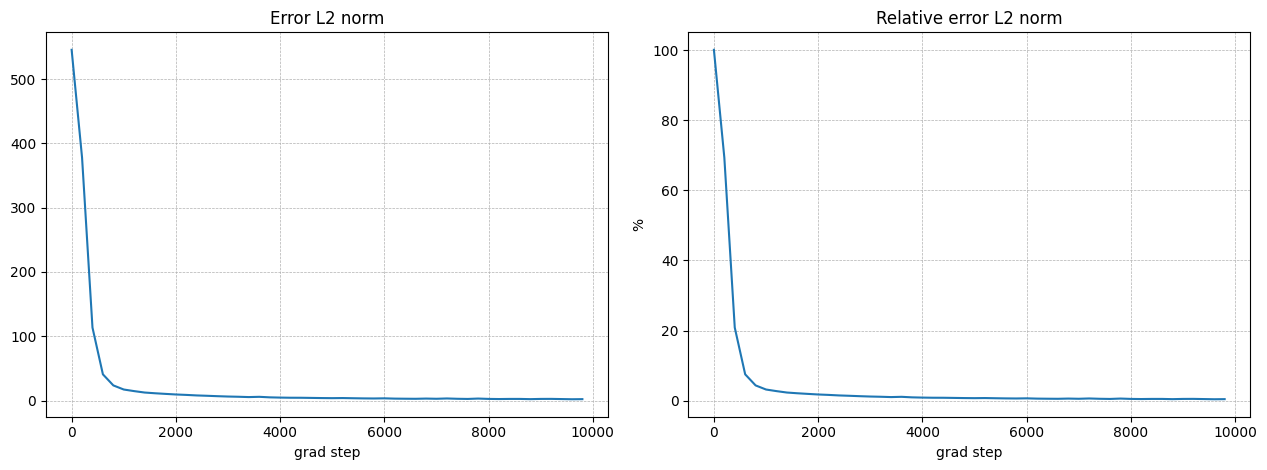

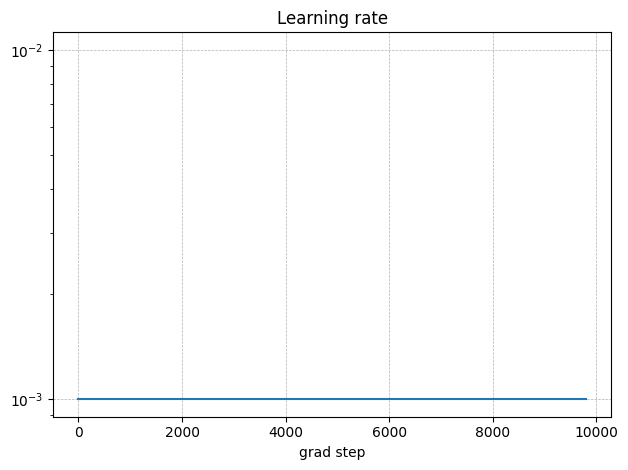

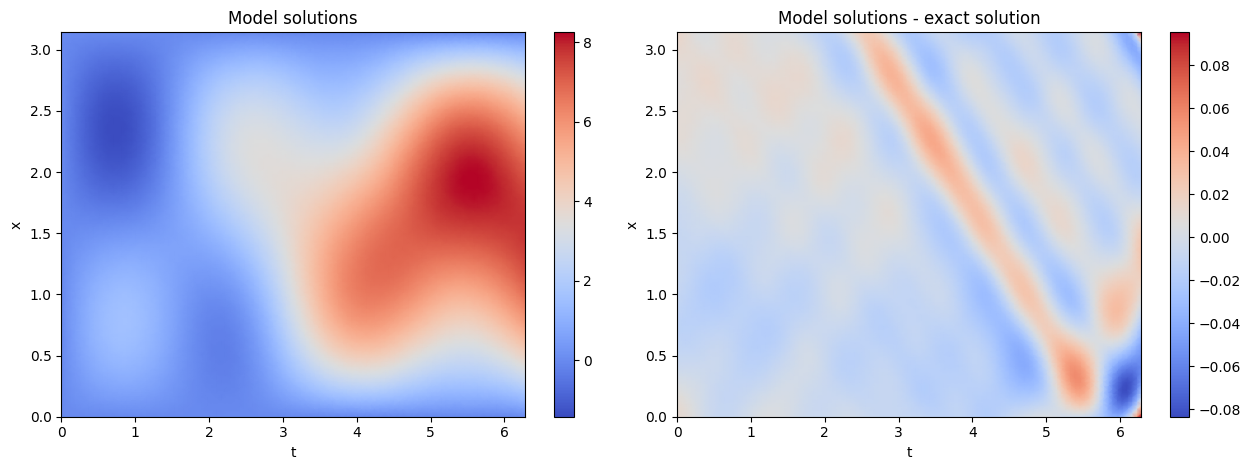

In [9]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "FFE_full",
    use_FFE=True,
    FFE_keep_dims=None)
model_ffe_full = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_ffe_full.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_ffe_full = Trainer(model_ffe_full, optimizer, scheduler, cfg=config)
metrics_ffe_full = trainer_ffe_full.train()

trainer_ffe_full.render_metrics_plots(metrics_ffe_full, save_to_disk=True)

Запуск обучения с частичным FFE для оси X

100%|██████████| 10000/10000 [03:24<00:00, 49.02it/s, loss=0.0034, err_l2=5.24, rel_err_l2=0.961, lambda_r=1, lambda_ic=1, lambda_bc=1] 


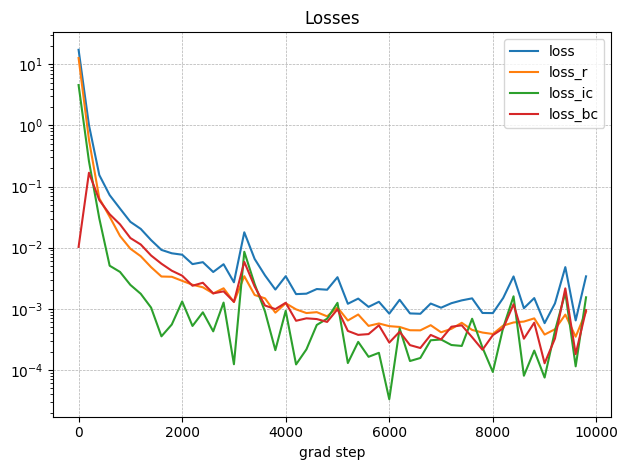

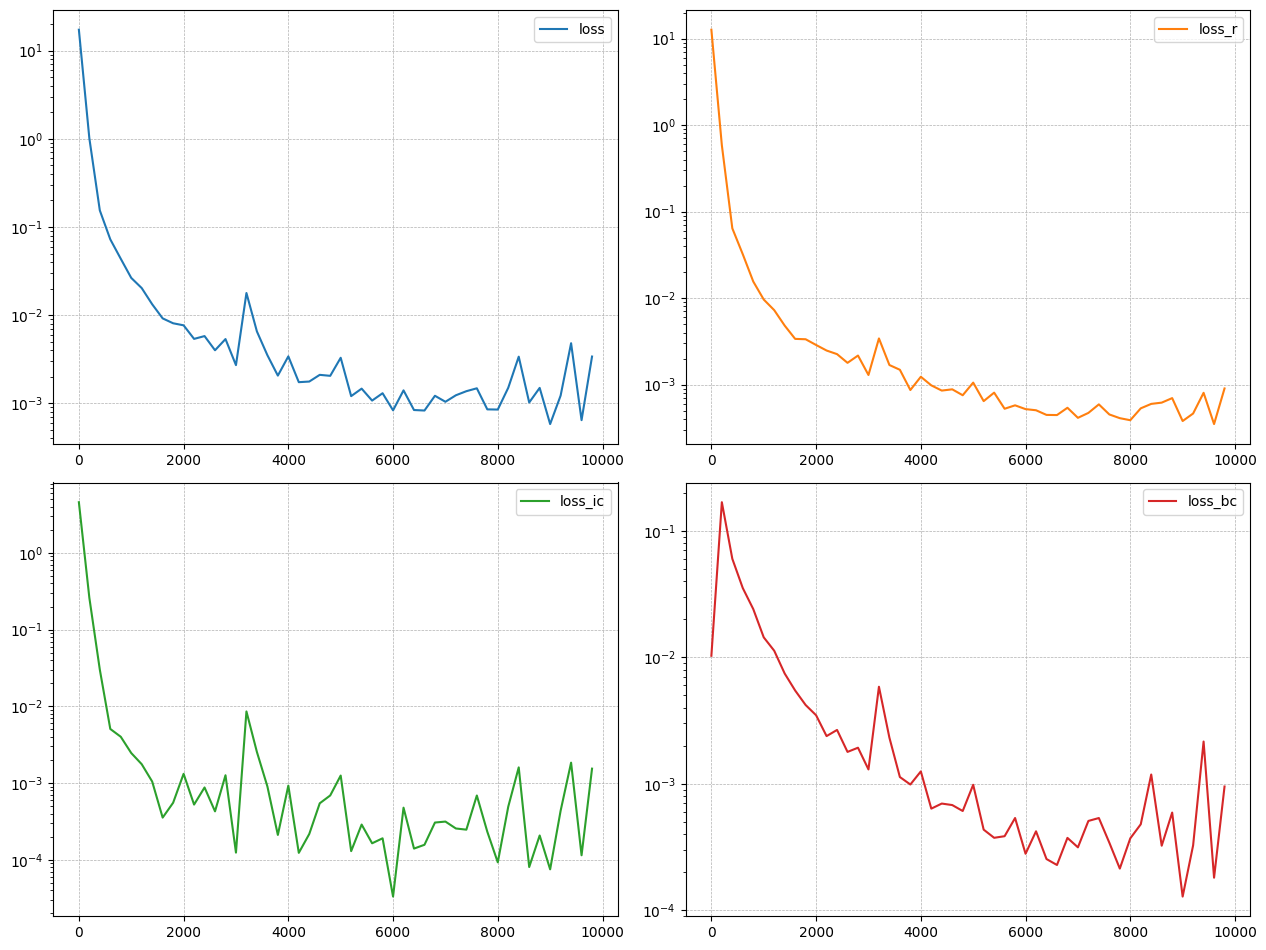

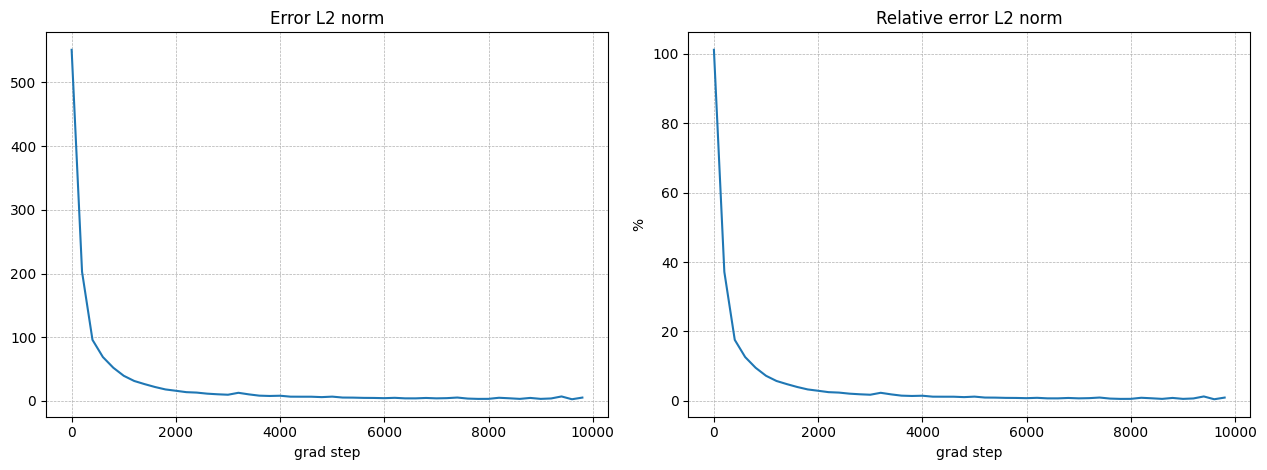

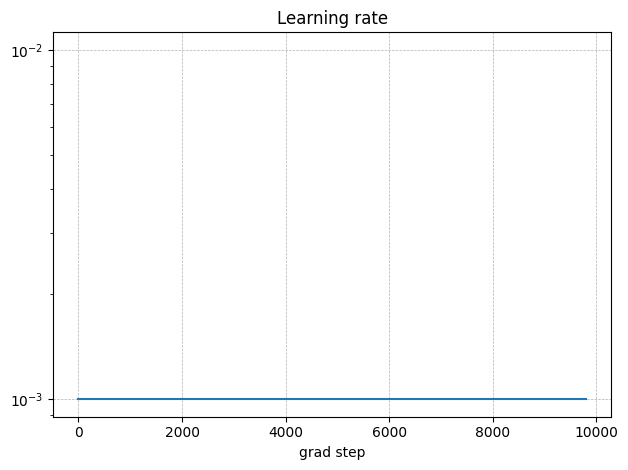

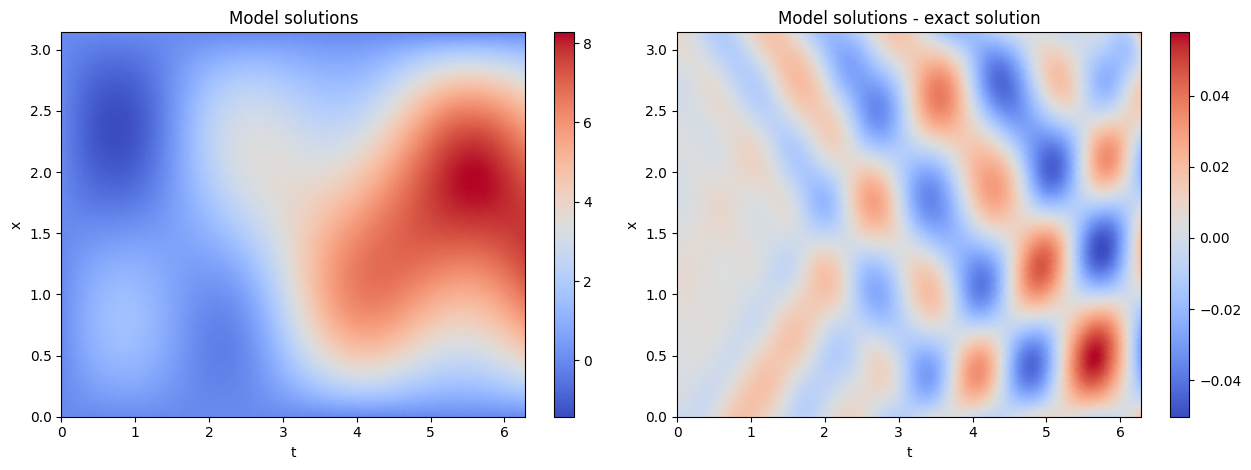

In [10]:
config = replace(
    config_baseline, results_folder=PINNConfig.results_folder / "FFE_partial",
    use_FFE=True,
    FFE_keep_dims=[1])
model_ffe_partial = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_ffe_partial.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_ffe_partial = Trainer(model_ffe_partial, optimizer, scheduler, cfg=config)
metrics_ffe_partial = trainer_ffe_partial.train()

trainer_ffe_partial.render_metrics_plots(metrics_ffe_partial, save_to_disk=True)

Запуск обучения с алгоритмом causal

100%|██████████| 10000/10000 [02:36<00:00, 64.05it/s, loss=0.00401, err_l2=9.35, rel_err_l2=1.72, lambda_r=1, lambda_ic=1, lambda_bc=1]


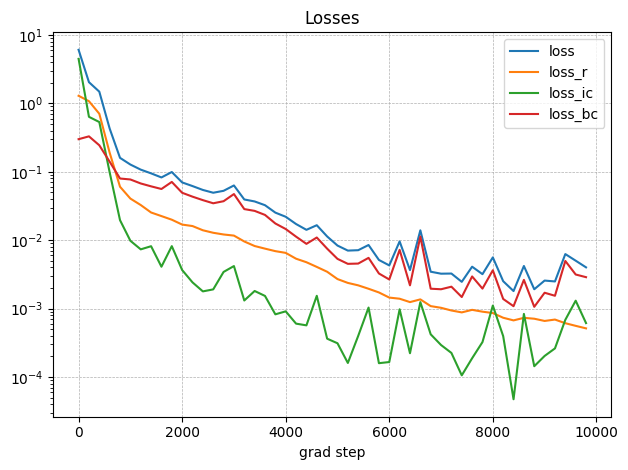

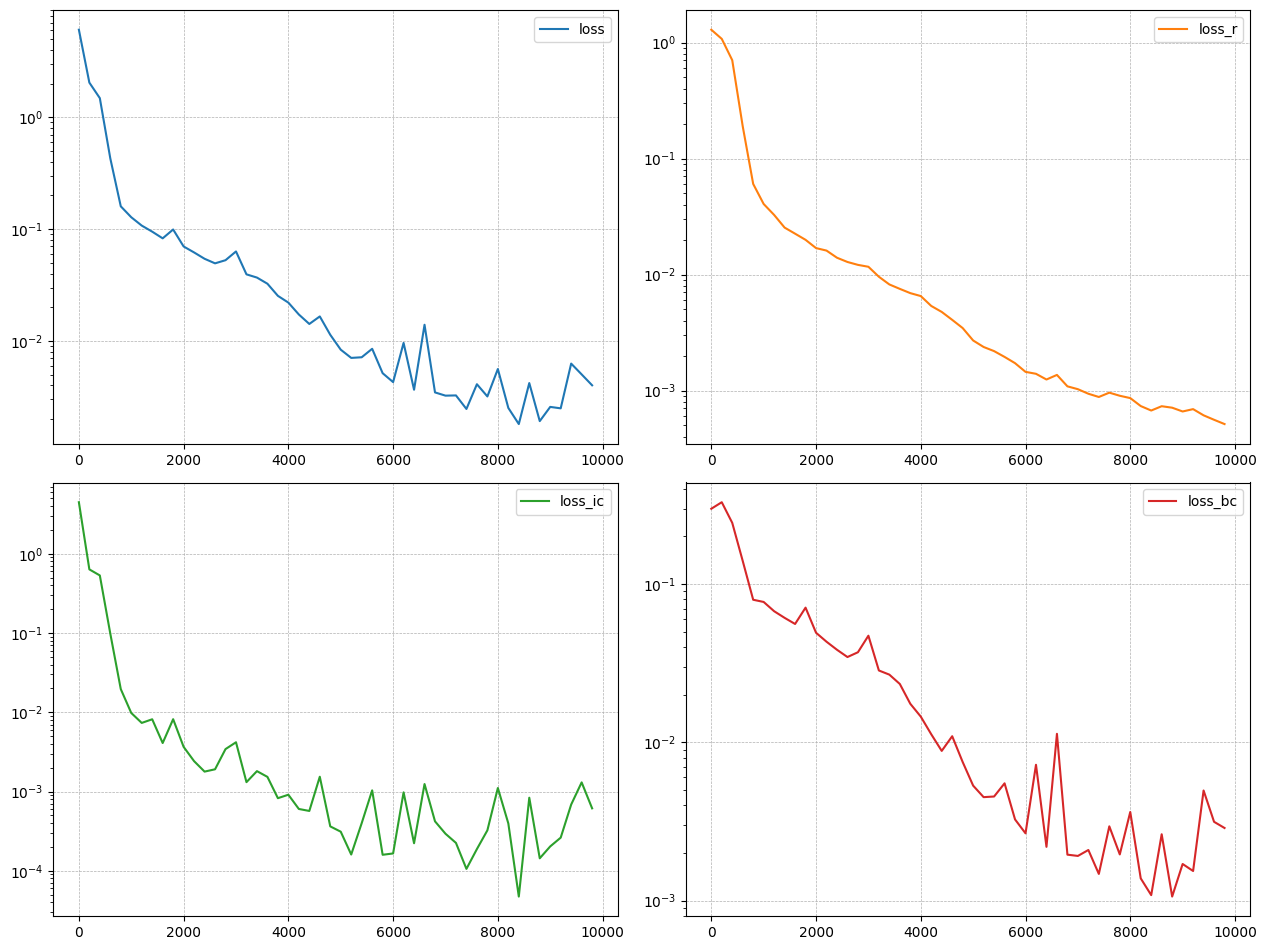

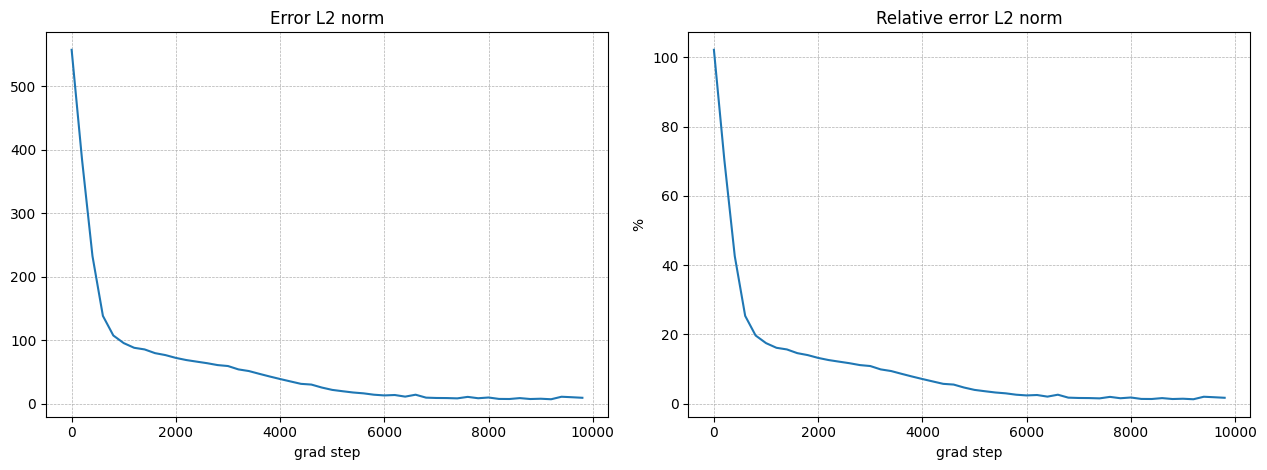

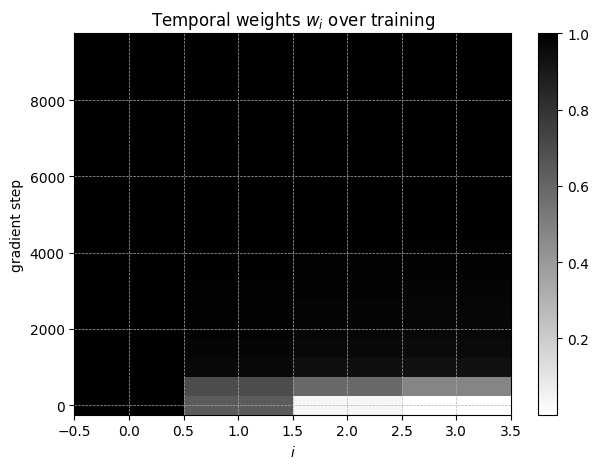

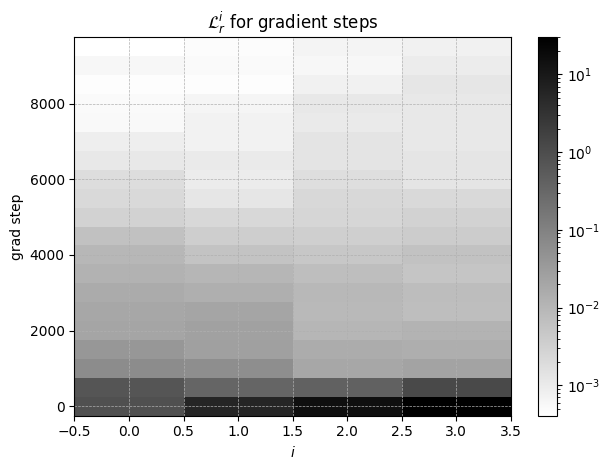

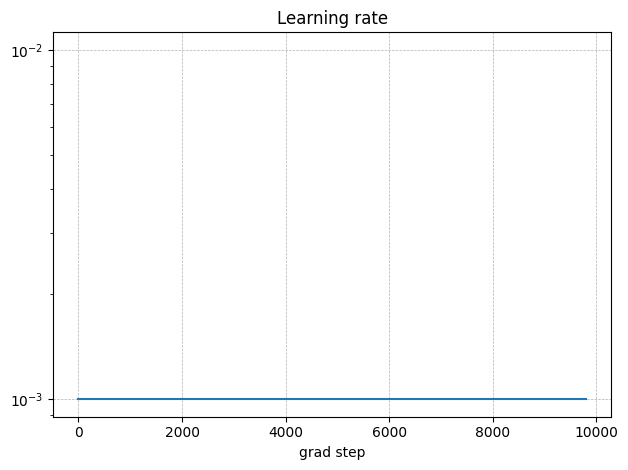

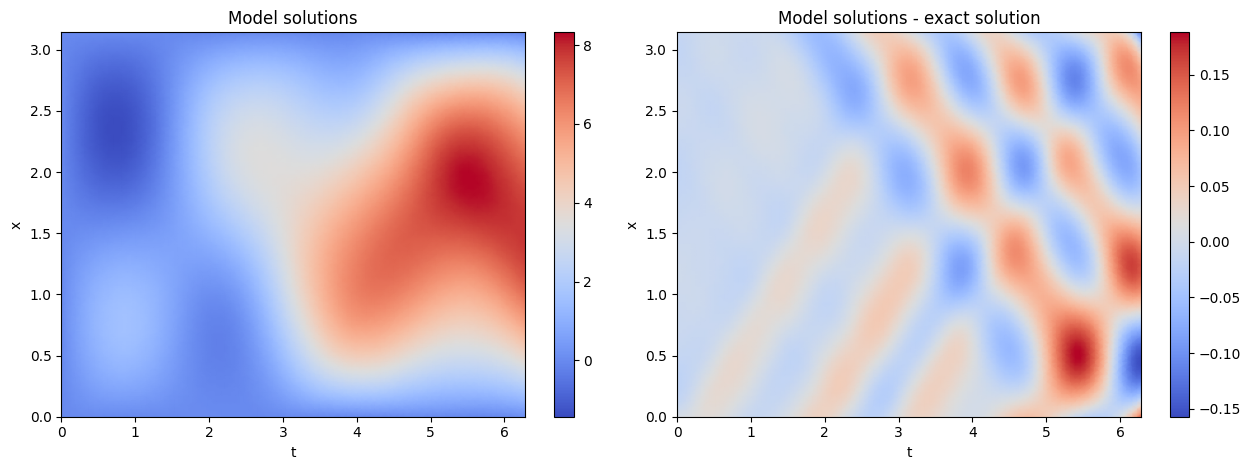

In [11]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "causal",
    use_causal_weighting_scheme=True
    )
model_causal = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_causal.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_causal = Trainer(model_causal, optimizer, scheduler, cfg=config)
metrics_causal = trainer_causal.train()

trainer_causal.render_metrics_plots(metrics_causal, save_to_disk=True)

Запуск обучения с балансировкой членов loss-функции

100%|██████████| 10000/10000 [02:19<00:00, 71.88it/s, loss=0.00734, err_l2=9.12, rel_err_l2=1.67, lambda_r=25.2, lambda_ic=5.04, lambda_bc=1.42]


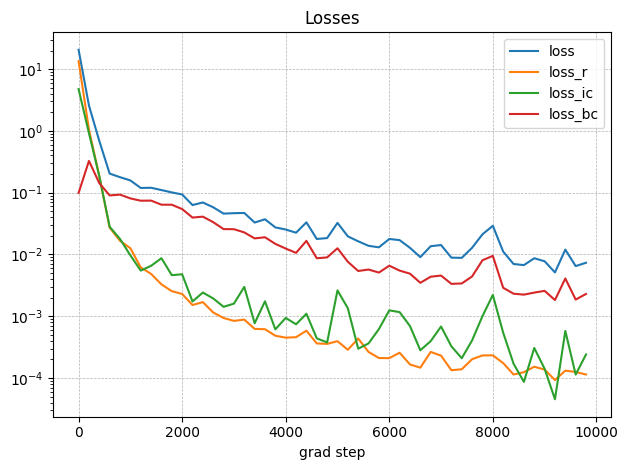

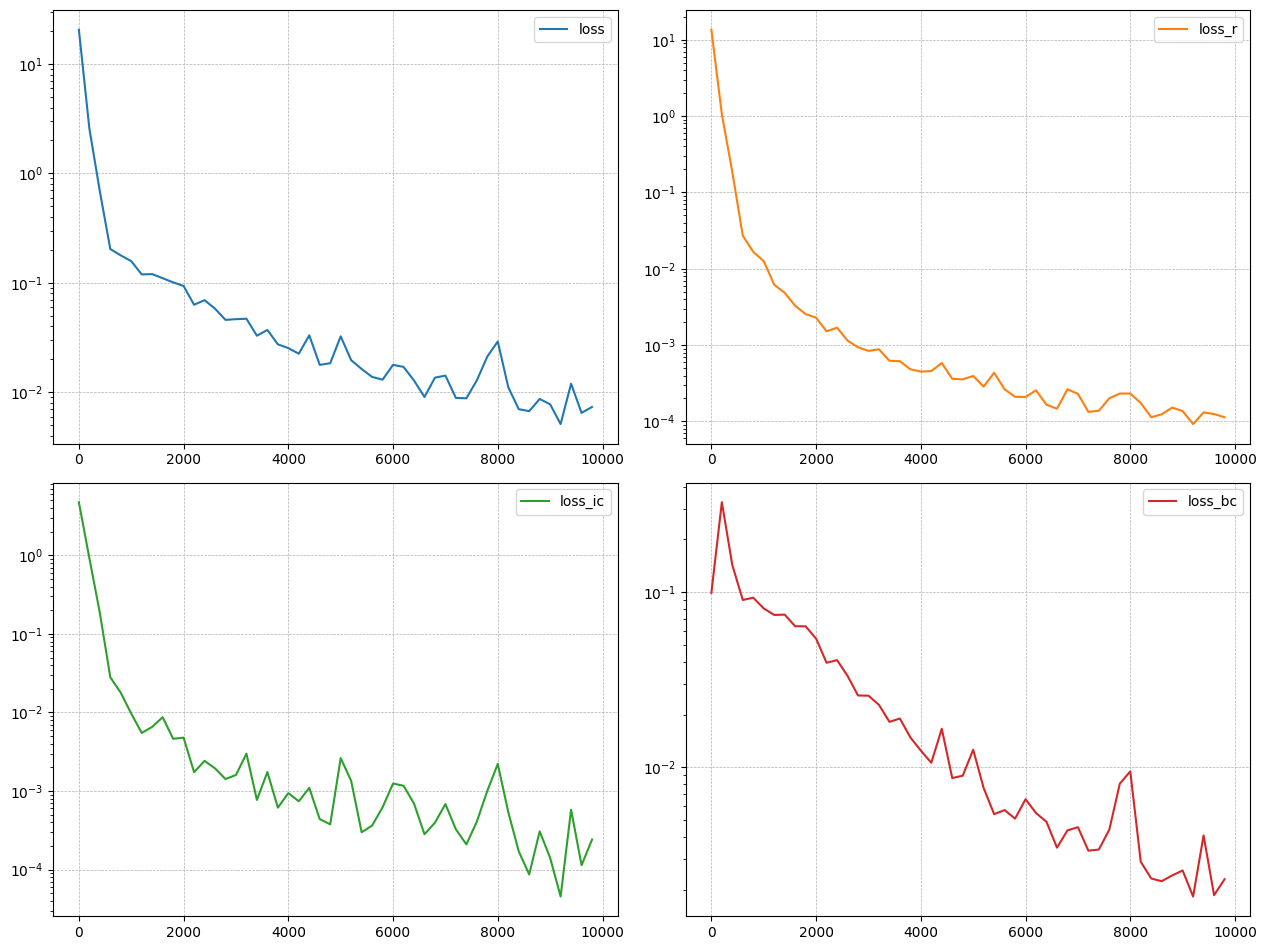

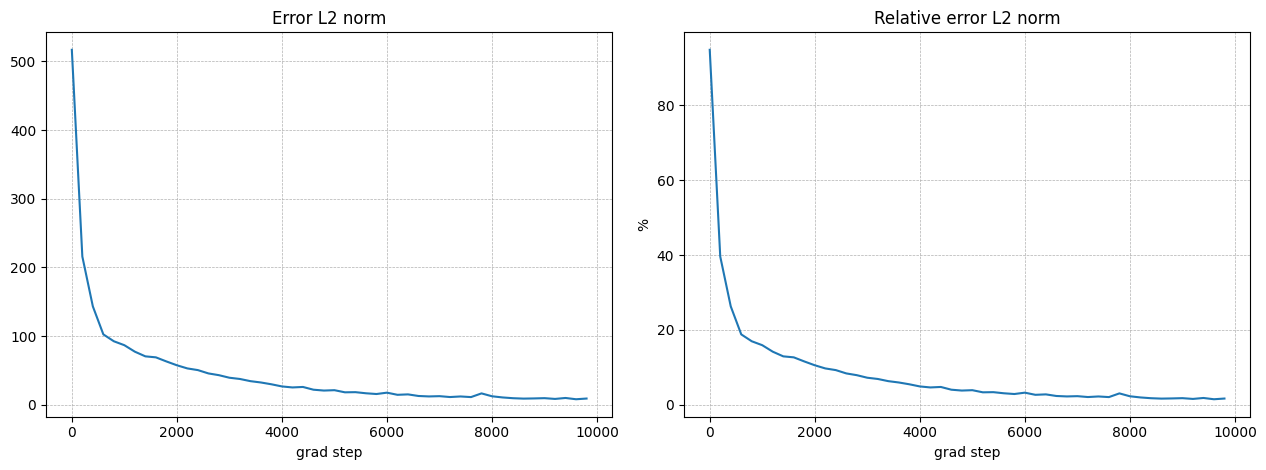

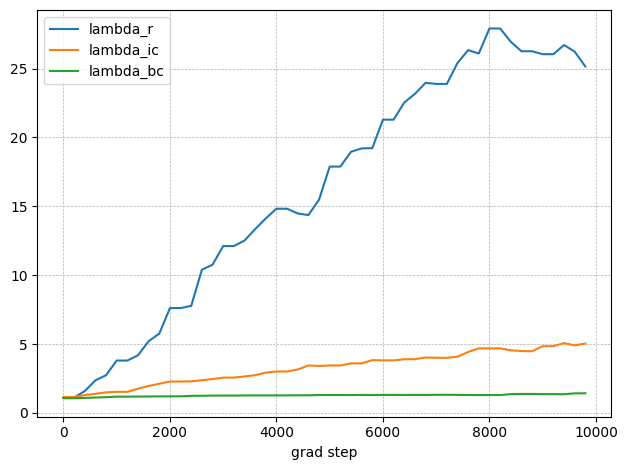

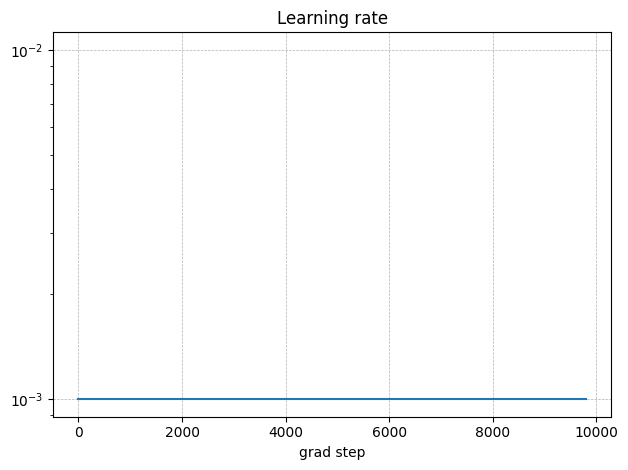

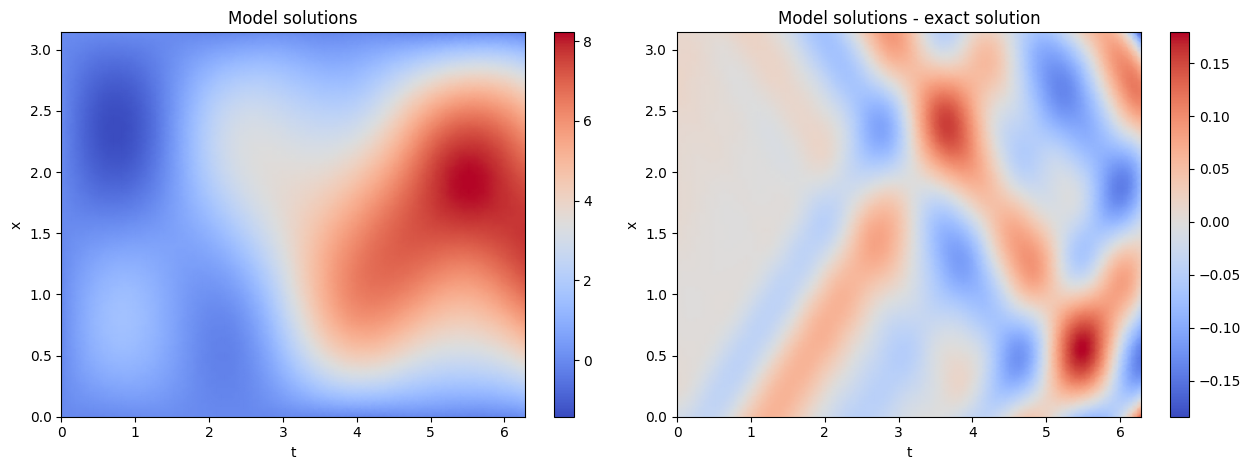

In [12]:
config = replace(
    config_baseline, 
    results_folder=PINNConfig.results_folder / "loss_balancing",
    use_grad_norm_weighting=True)
model_balancing = MultilayerPerceptronWithFFE(
    config.layers, config.init_scheme,
    use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
optimizer = torch.optim.Adam(model_balancing.parameters(), lr=config.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_balancing = Trainer(model_balancing, optimizer, scheduler, cfg=config)
metrics_balancing = trainer_balancing.train()

trainer_balancing.render_metrics_plots(metrics_balancing, save_to_disk=True)

Сравнение

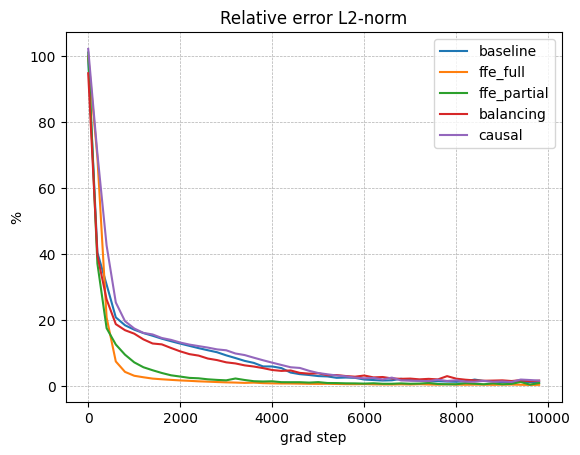

In [13]:
fig, ax = plt.subplots()
ax.plot(metrics_baseline['step'], metrics_baseline['rel_err_l2'], label='baseline')
ax.plot(metrics_ffe_full['step'], metrics_ffe_full['rel_err_l2'], label='ffe_full')
ax.plot(metrics_ffe_partial['step'], metrics_ffe_partial['rel_err_l2'], label='ffe_partial')
ax.plot(metrics_balancing['step'], metrics_balancing['rel_err_l2'], label='balancing')
ax.plot(metrics_causal['step'], metrics_causal['rel_err_l2'], label='causal')
ax.set(title="Relative error L2-norm", xlabel="grad step", ylabel="%")
ax.legend()
plt.show()
fig.savefig(PINNConfig.results_folder / "total_rel_err_l2_norm.png", dpi=300)